## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [1]:
# # 使用Colab可先run這裡的code
# # 假如要連結自己的雲端硬碟再開啟
# from google.colab import drive
# drive.mount('/content/gdrive')
# # 檢查GPU
# !nvidia-smi

## 記得先 pip install captcha

In [2]:
# 安裝產生驗證碼的套件
!pip install captcha

     |████████████████████████████████| 102kB 5.1MB/s 


## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
170 80 4 37


Text(0.5, 1.0, 'HV7Y')

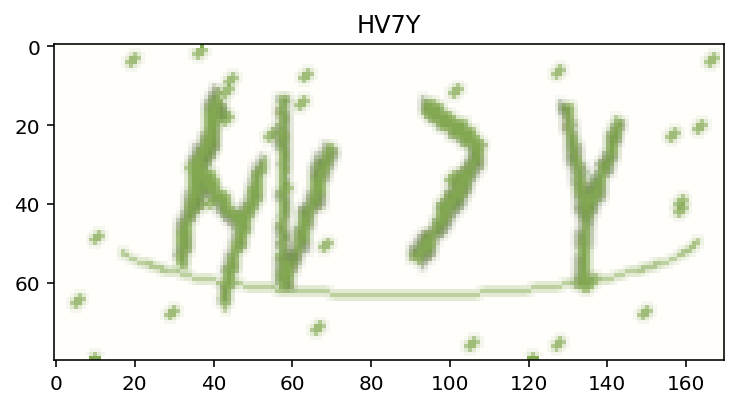

In [3]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

# 設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1
print(width, height, n_len, n_class)
# 設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

# 我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

TensorFlow 2.x selected.


In [5]:
# CTC Loss需要四個資訊，分別是
# Label
# 預測
# CNN OUTPUT寬度
# 預測影像所包含文字長度
def ctc_lambda_func(args):
  y_pred, labels, input_length, label_length = args
  return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [6]:
input_tensor = Input((height, width, 3))
x = input_tensor

# 自己設計CNN層
for i in range(4):
  x = Convolution2D(32, (3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = Convolution2D(32, (3, 3), activation='relu')(x)
  x = BatchNormalization()(x)

  if i < 3:
    x = MaxPooling2D()(x)
  else:
    x = MaxPooling2D(pool_size=(1, 1))(x)
 
# 記錄輸出CNN尺寸，loss部分需要這個資訊
# conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

# 從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)

# 包裝用來預測的model
base_model = Model(inputs=input_tensor, outputs=x)

# 設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,),
                  name='ctc')([x, labels, input_length, label_length])

# 這裡的model是用來計算loss
model = Model(inputs=[input_tensor, labels, input_length, label_length],
              outputs=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 78, 168, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization[0][0]        
____________________________________________________________________________________________

In [8]:
# 設計generator產生training data
# 產生包含要給loss的資訊
# X=輸入影像
# np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
# np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
  X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
  y = np.zeros((batch_size, n_len), dtype=np.uint8)

  while True:
    generator = ImageCaptcha(width=width, height=height)

    for i in range(batch_size):
      random_str = ''.join([random.choice(characters) for j in range(4)])
      X[i] = np.array(generator.generate_image(random_str))
      y[i] = [characters.find(x) for x in random_str]

    yield [X, y, np.ones(batch_size)*int(conv_shape[2]), \
           np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[ 5 21 29 35]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]


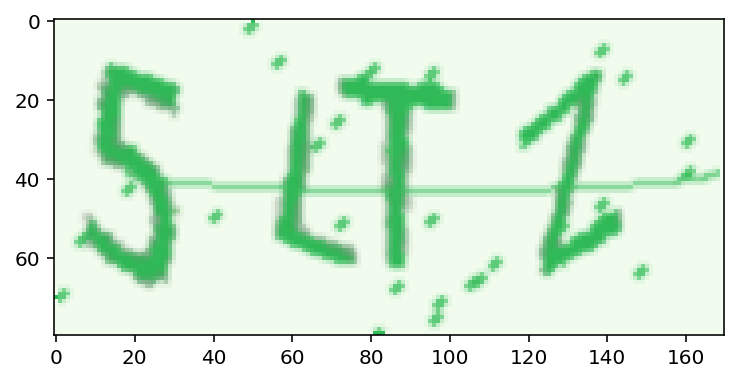

In [9]:
next_ge = gen(batch_size=1)
test_ge = next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ', test_ge[0][1])
print('CNN輸出寬度: ', test_ge[0][2])
print('字串長度(可浮動): ', test_ge[0][3])

## 開始訓練

In [10]:
model.fit(gen(32), steps_per_epoch=900, epochs=20)

  ...
    to  
  ['...']
Train for 900 steps
Epoch 1/20
900/900 [==============================] - 149s 166ms/step - loss: 15.4775
Epoch 2/20
900/900 [==============================] - 136s 152ms/step - loss: 9.7341
Epoch 3/20
900/900 [==============================] - 135s 150ms/step - loss: 5.0820
Epoch 4/20
900/900 [==============================] - 135s 150ms/step - loss: 4.0709
Epoch 5/20
900/900 [==============================] - 133s 148ms/step - loss: 3.5498
Epoch 6/20
900/900 [==============================] - 133s 148ms/step - loss: 3.3071
Epoch 7/20
900/900 [==============================] - 132s 146ms/step - loss: 3.0630
Epoch 8/20
900/900 [==============================] - 131s 146ms/step - loss: 2.9542
Epoch 9/20
900/900 [==============================] - 131s 146ms/step - loss: 2.8248
Epoch 10/20
900/900 [==============================] - 130s 145ms/step - loss: 2.6498
Epoch 11/20
900/900 [==============================] - 131s 146ms/step - loss: 2.5815
Epoch 12/20
900/9

## 預測

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


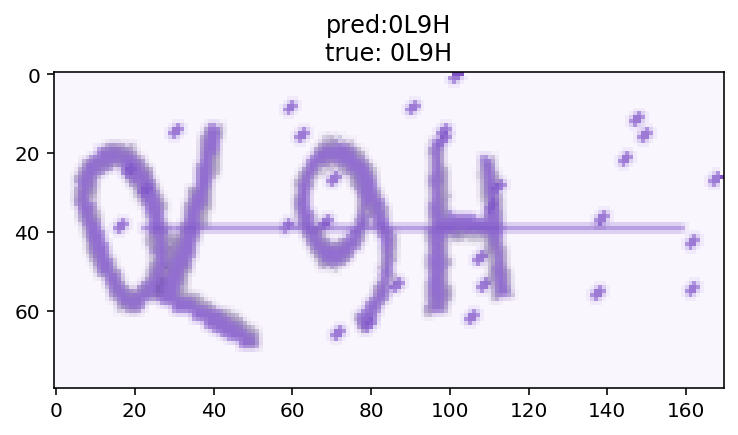

In [11]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)

# 用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred,
                               input_length=np.ones(y_pred.shape[0])*y_pred.shape[1],)[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

## 自己寫 decode CTC

In [12]:
# 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word = ''
n = ''

for single_result in y_pred[0].argmax(1):
  if single_result != 36:
    if n != single_result:
      word+=characters[single_result]
    n=single_result
print(word, n)

0L9H 17


## 額外參考：加入RNN的神經網路

In [13]:
rnn_size = 128

input_tensor = Input((height, width, 3))
x = input_tensor

for i in range(4):
  x = Convolution2D(32, (3, 3), activation='relu')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Convolution2D(32, (3, 3), activation='relu')(x)
  x = BatchNormalization(axis=-1)(x)

  if i < 3:
    x = MaxPooling2D(pool_size=(2, 2))(x)
  else:
    x = MaxPooling2D(pool_size=(2, 1))(x)

conv_shape = x.get_shape()

x = Reshape(target_shape=(int(conv_shape[2]),
                          int(conv_shape[1]*conv_shape[3])))(x)
x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal',
            name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True,
             kernel_initializer='he_normal', name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal',
            name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
             kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

x = Concatenate()([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,),
                  name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

In [14]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 78, 168, 32)  128         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [15]:
model.fit(gen(32), steps_per_epoch=900, epochs=20)

  ...
    to  
  ['...']
Train for 900 steps
Epoch 1/20
900/900 [==============================] - 140s 155ms/step - loss: 10.0162
Epoch 2/20
900/900 [==============================] - 135s 150ms/step - loss: 2.4365
Epoch 3/20
900/900 [==============================] - 135s 150ms/step - loss: 1.6607
Epoch 4/20
900/900 [==============================] - 135s 150ms/step - loss: 1.3462
Epoch 5/20
900/900 [==============================] - 138s 153ms/step - loss: 1.3249
Epoch 6/20
900/900 [==============================] - 139s 155ms/step - loss: 1.2550
Epoch 7/20
900/900 [==============================] - 144s 160ms/step - loss: 1.0085
Epoch 8/20
900/900 [==============================] - 145s 161ms/step - loss: 1.0020
Epoch 9/20
900/900 [==============================] - 145s 161ms/step - loss: 0.9588
Epoch 10/20
900/900 [==============================] - 146s 162ms/step - loss: 0.8803
Epoch 11/20
900/900 [==============================] - 147s 163ms/step - loss: 0.8796
Epoch 12/20
900/9

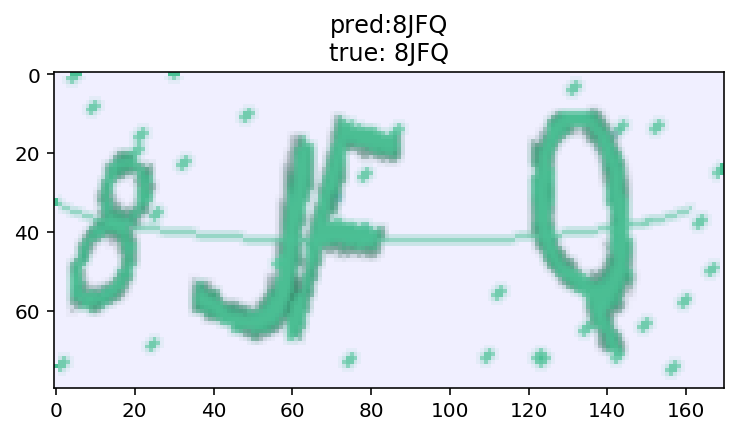

In [16]:
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)

# 用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred,
                               input_length=np.ones(y_pred.shape[0])*y_pred.shape[1],)[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

In [17]:
# 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word = ''
n = ''

for single_result in y_pred[0].argmax(1):
  if single_result != 36:
    if n != single_result:
      word+=characters[single_result]
    n=single_result
print(word, n)

8JFQ 26
